In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
from pylab import *
from scipy.optimize import curve_fit
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Energy as function of angle
dataDict = {
'State' : pd.Series(['FM','AFM','FM','AFM','FM','AFM','FM','AFM','FM','AFM','FM','AFM','FM','AFM'],index=['0','0', '15','15', '30','30','45','45','60','60','75','75','90', '90']),
'Total Energy' : pd.Series([-223.9842666, -223.9853412, -223.9849268,-223.9855121,-223.983616,-223.9858769,-223.9811426,-223.9856887,-223.977814,-223.9809027,-223.9666981,-223.9699511,-223.9487315,-223.9504364], index=['0','0', '15','15', '30','30','45','45','60','60','75','75','90', '90']),
'Energy Error' : pd.Series([0.000198749851,0.0002006422582,0.0002021910102,0.0001981985947,0.0002058370136,0.000197865291,0.0002035847029,0.0002077939487,0.0001998573641,0.0002029641835,0.0002013813606,0.0002082358912,0.0001978426595,0.0002056810956],index=['0','0', '15','15', '30','30','45','45','60','60','75','75','90', '90'])
}
keyData = pd.DataFrame(dataDict)

In [3]:
#Calculating energy differenes
angle =[0,15,30,45,60,75,90]
afm = []
fm = []
errfm=[]
errafm=[]
for index, row in keyData.iterrows():
    if row[1] == 'FM':
        fm.append(row[2])
        errfm.append(row[0])
    else:
        afm.append(row[2])
        errafm.append(row[0])
afm = np.asarray(afm)
fm = np.asarray(fm)
errfm=np.asarray(errfm)
errafm=np.asarray(errafm)
diff= afm-fm
errdiff = ((errafm)**2+(errfm)**2)**(1/2)

In [19]:
#Raw Data upload
df = pd.read_json('allobdm.json')
df=df.sort('angle')
df.index = range(0,len(df))
df

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,angle,downerr,downmatrix,state,uperr,upmatrix
0,0,"[[0.01660481124, 0.01645567583, 0.01692936186,...","[[0.08872400307, -0.01873891707, -0.0033873031...",FM,"[[0.03326404997, 0.008092531259999999, 0.00774...","[[0.9803081928, 0.0029962565249999997, -0.0068..."
1,0,"[[0.01578053015, 0.017787179939999998, 0.01606...","[[0.0699468021, 0.01205847272, 0.0106055519000...",AFM,"[[0.03163984685, 0.007970737108, 0.00738465636...","[[0.9900878325, -0.0060637413579999995, -0.000..."
2,15,"[[0.01845295867, 0.015020198609999999, 0.01697...","[[0.07400718433999999, -0.003029810651, -0.008...",AFM,"[[0.03214535781, 0.008510354264, 0.0067192764,...","[[0.9857886176, 0.001194987757, 0.00941171972,..."
3,15,"[[0.01620019172, 0.016229759349999998, 0.01609...","[[0.0372662239, 0.02069895674, -0.0315485874, ...",FM,"[[0.02945215482, 0.007375934927, 0.00859258270...","[[0.9837267749, 0.004388485197, -0.00067892670..."
4,30,"[[0.0163234929, 0.01525273854, 0.01928035428, ...","[[0.03769092455, 0.012604258129999999, 0.02060...",FM,"[[0.02874092292, 0.006986393325, 0.00867478052...","[[0.9843167767000001, -0.004072991838, 0.00566..."
5,30,"[[0.018286417939999997, 0.01781188306, 0.01626...","[[0.06597745206, -0.022352627469999997, 0.0427...",AFM,"[[0.03286648889, 0.007224579746, 0.00834297968...","[[0.9782063455000001, 0.009185732087, 0.003256..."
6,45,"[[0.01549163025, 0.0151220572, 0.01618905399, ...","[[0.01551029897, -0.0023356531779999998, 0.016...",FM,"[[0.02769825711, 0.007262866184, 0.00956705006...","[[0.9833630986, 0.00200683135, -0.008906288376..."
7,45,"[[0.016223838600000002, 0.01675950912, 0.01563...","[[0.037621380739999995, -0.01613862393, 0.0007...",AFM,"[[0.031056457939999997, 0.008082938583, 0.0090...","[[0.984744672, 0.001876350439, -0.003654608485..."
8,60,"[[0.01486845958, 0.01791343685, 0.01643127124,...","[[0.02898564356, 0.01794627348, 0.014270492749...",AFM,"[[0.03319608632, 0.00884062846, 0.007735443991...","[[0.9885053258000001, -0.01687113428, 0.002270..."
9,60,"[[0.016935555419999998, 0.01771655564, 0.01676...","[[0.03978539059, 0.022794333809999998, 0.02949...",FM,"[[0.03110488978, 0.007121325647, 0.01110313898...","[[0.9860858162, 0.0016956484399999999, -0.0080..."


In [5]:
#Fit function
def func(x, a, b):
    return a*np.exp(-b*(x))#+c

In [6]:
#Filter for which matrix elements are of most interest
def sigelements(matrix,siglist,storage):
    temp =[]
    for i in range(13):
        for j in range(13):
            if i == j:
                break
            elif abs(matrix[i][j]) > 0.05:  
                temp.append((i,j)) 
    storage['sig'] = temp
    siglist.append(storage)
    return siglist

In [7]:
#Construct lists of interesting coordinates for up and down spins
sigupfm = []
sigupafm = []
for i in range(14):
    storage = {'angle':df['angle'][i], 'sig':[]}
    if df['state'][i] == 'FM':
        obdm = df['upmatrix'][i]
        sigelements(obdm,sigupfm,storage)
    else:
        obdm = df['upmatrix'][i]
        sigelements(obdm,sigupafm,storage)

sigdownfm = []
sigdownafm = []
for i in range(14):
    storage = {'angle':df['angle'][i], 'sig':[]}
    if df['state'][i] == 'FM':
        obdm = df['downmatrix'][i]
        sigelements(obdm,sigdownfm,storage)
    else:
        obdm = df['downmatrix'][i]
        sigelements(obdm,sigdownafm,storage)
sigupafm

[{'angle': 0, 'sig': [(8, 7), (9, 5), (10, 6)]},
 {'angle': 15, 'sig': [(8, 7), (9, 5), (10, 6), (11, 10)]},
 {'angle': 30, 'sig': [(7, 6), (8, 7), (9, 5), (10, 6)]},
 {'angle': 45, 'sig': [(7, 6), (8, 7), (9, 5), (10, 6)]},
 {'angle': 60, 'sig': [(8, 7), (9, 5), (10, 6)]},
 {'angle': 75, 'sig': [(8, 7), (9, 5), (10, 6)]},
 {'angle': 90, 'sig': [(6, 3), (7, 6), (8, 7), (9, 5), (10, 6)]}]

In [8]:
#Pull OBDM elements based on interesting coordinates
def obdmelements(angle,matrix,errmatrix,coordinates,out):
    storage = {'angle':angle, 'value':0,'err':0,'coord':coordinates}
    storage['value'] = matrix[coordinates[0]][coordinates[1]]
    storage['err'] = errmatrix[coordinates[0]][coordinates[1]]
    return out.append(storage)

In [9]:
#For each magnetic state and spin, compile the matrix elements associated with each coordinate
fmupcoord = [(7,6)]
fmup = [] 
for i in range(14):
    if df['state'][i] =='FM':
        for coord in fmupcoord:
            obdmelements(df['angle'][i],df['upmatrix'][i],df['uperr'][i],coord,fmup)

            
fmdowncoord = [(6,2),(7,0)]
fmdown =[]
for i in range(14):
    if df['state'][i] =='FM':
        for coord in fmdowncoord:
            obdmelements(df['angle'][i],df['downmatrix'][i],df['downerr'][i],coord,fmdown)

            
afmupcoord = [(10,6)]
afmup = []
for i in range(14):
    if df['state'][i] =='AFM':
        for coord in afmupcoord:
            obdmelements(df['angle'][i],df['upmatrix'][i],df['uperr'][i],coord,afmup)

afmdowncoord = [(6,2),(7,0)]
afmdown = []
for i in range(14):
    if df['state'][i] =='AFM':
        for coord in afmdowncoord:
            obdmelements(df['angle'][i],df['downmatrix'][i],df['downerr'][i],coord,afmdown)

In [10]:
#Group particular matrix elements together from the grand list
afmdown.sort(key=itemgetter('coord'))
ad =[]
for key,items in itertools.groupby(afmdown,itemgetter('coord')):
    ad.append(list(items)) 

afmup.sort(key=itemgetter('coord'))
au =[]
for key,items in itertools.groupby(afmup,itemgetter('coord')):
    au.append(list(items)) 

fmup.sort(key=itemgetter('coord'))
fu =[]
for key,items in itertools.groupby(fmup,itemgetter('coord')):
    fu.append(list(items)) 

fmdown.sort(key=itemgetter('coord'))
fd =[]
for key,items in itertools.groupby(fmdown,itemgetter('coord')):
    fd.append(list(items)) 

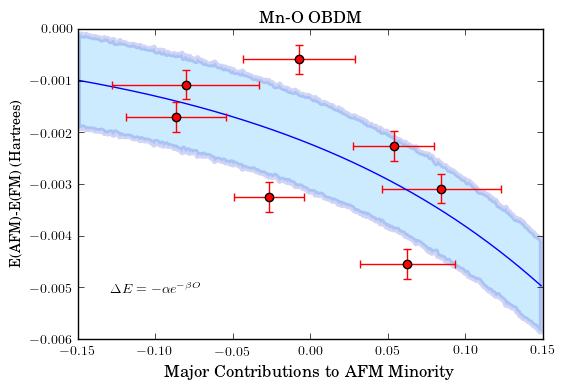

In [107]:
check = ad[0]
check2  = ad[1]

obdmelem = []
obdmerr = []
obdmelem2 = []
obdmerr2 = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
    obdmelem2.append(check2[i]['value'])
    obdmerr2.append(check2[i]['err'])
obdmelem = [sum(x) for x in zip(obdmelem, obdmelem2)]
obdmerr = [i**2 for i in obdmerr]
obdmerr2 = [i**2 for i in obdmerr2]
obdmerr = [math.sqrt(sum(x)) for x in zip(obdmerr, obdmerr2)]
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)


inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [52,0.0015])
x=np.arange(-0.15, 0.15, .001)
y= popt[0]*exp(-popt[1]*x)#+popt[2]
error = np.random.normal(0.0009, 0.00002, size=y.shape)
plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, antialiased=True)
plt.plot(x, y)
plt.text(-0.1, -0.005,r'$\Delta E = -\alpha e^{-\beta O}$', horizontalalignment='center',
     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('E(AFM)-E(FM) (Hartrees)')
plt.xlabel('Major Contributions to AFM Minority',size=12)
plt.title('Mn-O OBDM')
#plt.xlim(-0.32, 0.23)
plt.show()

In [108]:
#Analysis of all hoppings between Manganese and Oxygen -- no filtering to be done
#(567)x(01234)
def sumelements(matrix,error,sumlist,storage):
    temp =[]
    errtemp = []
    for i in range(5,8):
        for j in range(0,5):
#            if abs(matrix[i][j]) > 0.05:
                temp.append(matrix[i][j])
                errtemp.append(error[i][j])
    for i in range(5,8):
        for j in range(0,5):
#            if abs(matrix[j][i]) > 0.05:
                temp.append(matrix[j][i])
                errtemp.append(error[j][i])     
    for i in range(5,8):
        for j in range(8,13):
#            if abs(matrix[j][i]) > 0.05:
                temp.append(matrix[j][i])
                errtemp.append(error[j][i]) 
    for i in range(5,8):
        for j in range(8,13):
#            if abs(matrix[i][j]) > 0.05:
                temp.append(matrix[i][j])
                errtemp.append(error[i][j])
                
    errtemp = [i**2 for i in errtemp]
    toterr =math.sqrt(sum(errtemp)) 
    storage['sum'] = sum(temp)
    storage['error'] = toterr
    sumlist.append(storage)
    return sumlist

In [109]:
sumupfm = []
sumupafm = []
for i in range(14):
    storage = {'angle':df['angle'][i], 'sum':[],'error':[]}
    if df['state'][i] == 'FM':
        obdm = df['upmatrix'][i]
        err= df['uperr'][i]
        sumelements(obdm,err,sumupfm,storage)
    else:
        obdm = df['upmatrix'][i]
        err= df['uperr'][i]
        sumelements(obdm,err,sumupafm,storage)

sumdownfm = []
sumdownafm = []
for i in range(14):
    storage = {'angle':df['angle'][i], 'sum':[]}
    if df['state'][i] == 'FM':
        obdm = df['downmatrix'][i]
        err= df['downerr'][i]
        sumelements(obdm,err,sumdownfm,storage)
    else:
        obdm = df['downmatrix'][i]
        err= df['downerr'][i]
        sumelements(obdm,err,sumdownafm,storage)
sumdownfm

[{'angle': 0, 'error': 0.13991565763254213, 'sum': 0.031699439450399998},
 {'angle': 15, 'error': 0.1268495201281653, 'sum': 0.59490405744110009},
 {'angle': 30, 'error': 0.12682995523879265, 'sum': 0.28072142400250999},
 {'angle': 45, 'error': 0.11077882640761574, 'sum': 0.23770726493950003},
 {'angle': 60, 'error': 0.12419724512650485, 'sum': -0.64567127019510007},
 {'angle': 75, 'error': 0.12299082838413931, 'sum': -0.77878348830165001},
 {'angle': 90, 'error': 0.1382111580996009, 'sum': -0.7513705124835699}]

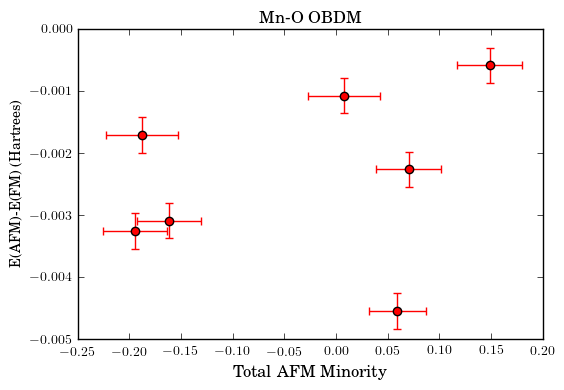

In [110]:
obdmelem = []
obdmerr = []
for i in range(len(sumdownfm)):
    obdmelem.append(sumdownfm[i]['sum'])
    obdmerr.append(sumdownfm[i]['error'])
obdmelem = np.asarray(obdmelem)/4
obdmerr = np.asarray(obdmerr)/4
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('E(AFM)-E(FM) (Hartrees)')
plt.xlabel('Total AFM Minority',size=12)
plt.title('Mn-O OBDM')
#plt.xlim(-0.32, 0.23)
plt.show()